In [18]:
"The goal of this exercise is to better understand the inner workings of a Decision Tree and how " \
"the boundaries are computed, such as follows."

'The goal of this exercise is to better understand the inner workings of a Decision Tree and how the boundaries are computed, such as follows.'

In [19]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [20]:
tree_df = pd.read_csv('two_classes.csv')
tree_df.head()

,x1,x2,y
0,143,139,1
1,117,130,0
2,235,331,1
3,230,298,1
4,280,277,0


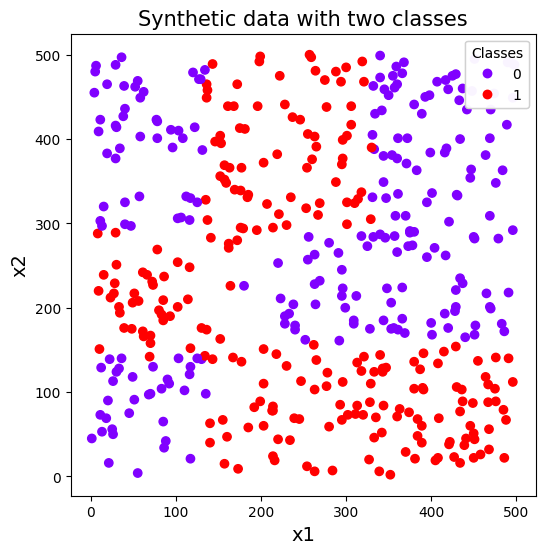

In [21]:
# Plot the data to visualize class patterns

# Create figure of specific size and the axes objects
fig, ax = plt.subplots(figsize=(6,6))

# Scatter the data points
# Other colormaps could be found here:
# https://stackoverflow.com/questions/34314356/how-to-view-all-colormaps-available-in-matplotlib
scatter = ax.scatter(tree_df['x1'], tree_df['x2'], c=tree_df['y'], cmap='rainbow')

# Create a legend object with title "Classes" and specified location on the plot
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax.add_artist(legend)

# Add labeling to the plot
ax.set_xlabel('x1', fontsize='14')
ax.set_ylabel('x2', fontsize='14')
ax.set_title('Synthetic data with two classes', fontsize='15')

# Display the plot
plt.show()

In [22]:
def get_total_gini(predictor_values, pred_name, df):
    '''
    Parameters: an array of _unique_ predictor values,
                a name of the predictor (String),
                a corresponding dataframe object.
    Returns: an array of total Gini index for each provided predictor value.
    '''

    total_gini = []
    
    for i in predictor_values:
    
        # Left Leaf
        # counts of each class (1 or 0) to the left of candidate split
        left_df = df[df[pred_name] < i]
        left_1 = np.sum(left_df['y'] == 1)
        left_0 = np.sum(left_df['y'] == 0)
        
        # total number of points on the left
        N_left = left_1 + left_0

        # Gini impurity for the left leaf
        if N_left > 0:
          gini_left = 1 - (left_1/N_left)**2 - (left_0/N_left)**2
        else:
          gini_left = 0
        
        # Right Leaf
        # counts of each class (1 or 0) to the right of candidate split
        right_df = df[df[pred_name] >= i]
        right_1 = np.sum(right_df['y'] == 1)
        right_0 = np.sum(right_df['y'] == 0)
    
        # total number of points on the right
        N_right = right_1 + right_0
        
        if N_right > 0:
            gini_right = 1 - (right_1/N_right)**2 - (right_0/N_right)**2
        else:
            gini_right = 0

        # total number of points in both leaves
        N_total = N_left + N_right

        # total weighted gini impurity index
        if N_total > 0:
           total_gini.append(round(((N_left/N_total)*gini_left) + ((N_right/N_total)*gini_right), 6))
        else:
            total_gini.append(0)
    
    return total_gini


In [23]:
### edTest(test_x1_unique_values) ###

# Get unique values of x1
x1_unique = np.sort(tree_df['x1'].unique())

In [24]:
### edTest(test_x2_unique_values) ###

# Get unique values of x2
x2_unique = np.sort(tree_df['x2'].unique())

In [25]:
### edTest(test_x1_total_gini) ###

# get total Gini index for x1
x1_total_gini = get_total_gini(x1_unique, 'x1', tree_df)

In [26]:
### edTest(test_x2_total_gini) ###

# get total Gini index for x2
x2_total_gini = get_total_gini(x2_unique, 'x2', tree_df)

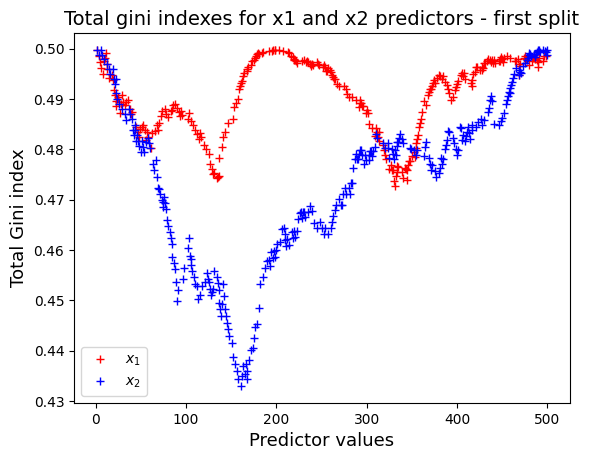

In [27]:
# plot the resulting total Gini indexes for each predictor
plt.plot(x1_unique, x1_total_gini, 'r+', label="$x_1$")
plt.plot(x2_unique, x2_total_gini, 'b+', label="$x_2$")
plt.xlabel("Predictor values", fontsize="13")
plt.ylabel("Total Gini index", fontsize="13")
plt.title("Total gini indexes for x1 and x2 predictors - first split", fontsize="14")
plt.legend()
plt.show()

In [28]:
def report_splits(x1_unique, x2_unique, x1_total_gini, x2_total_gini):
     # predictor providing the split with the lowest gini (x1=0, x2=1)
     best_pred = np.argmin([min(x1_total_gini), min(x2_total_gini)])
     # index of lowest gini score for best predictor 
     best_gini_idx = np.argmin([x1_total_gini, x2_total_gini][best_pred])
     # best predictor value corresponding to that lowest gini score
     best_pred_value = [x1_unique, x2_unique][best_pred][best_gini_idx]
     print("The lowest total gini score is achieved when splitting on "+\
          f"{['x1','x2'][best_pred]} at the value {best_pred_value}.")
          
report_splits(x1_unique, x2_unique, x1_total_gini, x2_total_gini)

The lowest total gini score is achieved when splitting on x2 at the value 161.


In [29]:
### edTest(test_first_threshold) ###

# Find the threshold to split on
def get_threshold(unique_values, gini_scores):
    # Ensure unique values are sorted
    unique_values = np.sort(unique_values)
    
    # Get index of the minimum Gini score
    idx = np.argmin(gini_scores)
    
    # Safeguard against edge cases
    if idx + 1 >= len(unique_values):
        raise ValueError("Cannot compute a threshold for the last unique value.")
    
    # Compute the threshold as the midpoint
    threshold = (unique_values[idx] + unique_values[idx + 1]) / 2
    return threshold

x2_threshold = get_threshold(x2_unique, x2_total_gini)
print(f"Our threshold will be {x2_threshold}")

Our threshold will be 161.5


In [30]:
def get_split_labels(splits):
    '''
    Parameters:
        splits: List of ('predictor name', threshold) tuples
                Ex: [('x1', 42), ('x2', 109)]
    Returns: List of dictionaries, one for each split. 
             Dictionaries contain class labels for each side of the split
    '''
    split_labels = []
    region = tree_df
    for pred, thresh in splits:
        region_labels = {
            'left': region.loc[region[pred] <= thresh, 'y'].mode().values[0],
            'right': region.loc[region[pred] > thresh, 'y'].mode().values[0]
        }
        split_labels.append(region_labels)
        region = region[region[pred] <= thresh]
    return split_labels

# Example of how get_split_labels works
splits = [('x2', x2_threshold)]
split_labels = get_split_labels(splits)
print('class labels for the children of the root node:', split_labels)

class labels for the children of the root node: [{'left': np.int64(1), 'right': np.int64(0)}]


In [31]:
def predict_class(x1, x2, splits):
    # get split labels to use when predicting
    split_labels = get_split_labels(splits)
    y_hats = []
    # iterate over each data point
    for x1_i, x2_i in zip(x1.ravel(), x2.ravel()):
        # dict lets us specify a predictor based on split rule
        obs = {'x1': x1_i, 'x2': x2_i}
        # apply each split rule
        for n_split, (pred, thresh) in enumerate(splits):
            # left
            if obs[pred] <= thresh:
                if n_split == len(splits)-1:
                    y_hats.append(split_labels[n_split]['left'])
            # right
            else:
                y_hats.append(split_labels[n_split]['right'])
                break
    return np.array(y_hats)

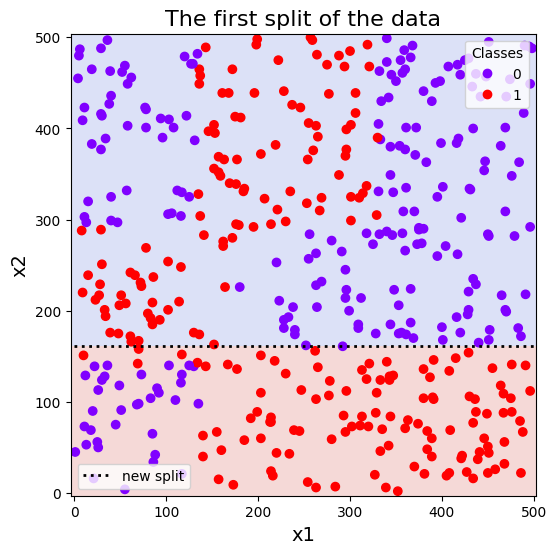

In [32]:
# Plot the split:
# Create figure of specific size and the axes objects
fig, ax = plt.subplots(figsize=(6, 6))

# Scatter the data points
# Other colormaps could be found here:
# https://stackoverflow.com/questions/34314356/how-to-view-all-colormaps-available-in-matplotlib
scatter = ax.scatter(tree_df['x1'], tree_df['x2'], c=tree_df['y'], cmap='rainbow')

# Create a legend object with title "Classes" and specified location on the plot
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax.add_artist(legend)

# Split line
ax.hlines(x2_threshold, xmin=0, xmax=500,
          color ='black', lw = 2, ls=':', label='new split')
ax.legend()

# Add labeling to the plot
ax.set_xlabel('x1', fontsize='14')
ax.set_ylabel('x2', fontsize='14')
ax.set_title('The first split of the data', fontsize='16')

# Plot decision regions
# dummy x1 & x2 grid values to predict on
eps = 5 # padding for the grid
xx1, xx2 = np.meshgrid(np.arange(tree_df['x1'].min()-eps, tree_df['x1'].max()+eps, 1),
                       np.arange(tree_df['x2'].min()-eps, tree_df['x2'].max()+eps, 1))
# predict class labels on grid points
class_pred = predict_class(xx1, xx2, splits)
# contour plot for decision regions
plt.contourf(xx1, xx2, class_pred.reshape(xx1.shape), alpha=0.2, zorder=-1, cmap=plt.cm.coolwarm)

# Display the plot
plt.show()

In [33]:
first_split_df = tree_df[tree_df['x2'] <= x2_threshold]
# Peak at the result
first_split_df.head()

,x1,x2,y
0,143,139,1
1,117,130,0
14,265,138,1
18,230,131,1
20,140,63,1


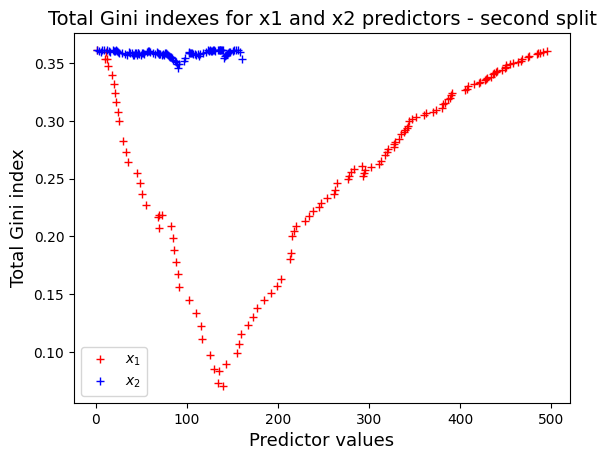

In [34]:
# provide unique values from our new dataframe
x1_unique_2split = np.unique(first_split_df['x1'].values)
x2_unique_2split = np.unique(first_split_df['x2'].values)

tot_gini_x1_2split = get_total_gini(x1_unique_2split, 'x1', first_split_df)
tot_gini_x2_2split = get_total_gini(x2_unique_2split, 'x2', first_split_df)

plt.plot(x1_unique_2split, tot_gini_x1_2split, 'r+', label='$x_1$')
plt.plot(x2_unique_2split, tot_gini_x2_2split, 'b+', label='$x_2$')
plt.xlabel("Predictor values", fontsize="13")
plt.ylabel("Total Gini index", fontsize="13")
plt.title("Total Gini indexes for x1 and x2 predictors - second split", fontsize="14")
plt.legend()
plt.show()

In [35]:
report_splits(x1_unique_2split, x2_unique_2split,
              tot_gini_x1_2split, tot_gini_x2_2split)

The lowest total gini score is achieved when splitting on x1 at the value 140.


In [36]:
### edTest(test_second_threshold) ###

# The value to split on
# Hint: be sure to use the variables defined 
# in the 2 cells above!
x1_threshold_2split = get_threshold(x1_unique_2split, tot_gini_x1_2split)
print(f"Our threshold will be {x1_threshold_2split}")

Our threshold will be 141.5


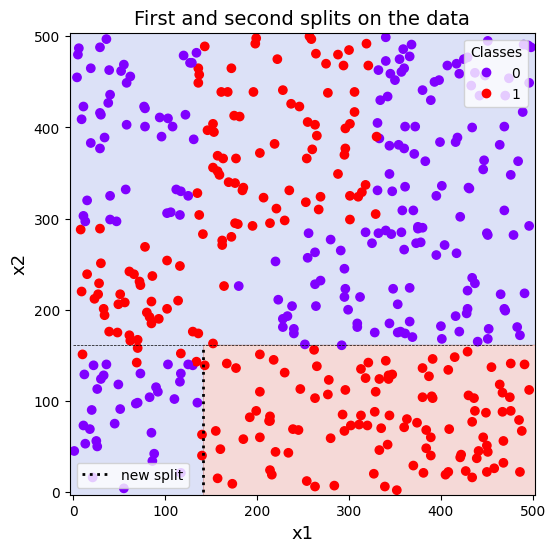

In [37]:
# Plot the split:
# Create figure of specific size and the axes objects
fig, ax = plt.subplots(figsize=(6, 6))

# Scatter the data points
scatter = ax.scatter(tree_df['x1'], tree_df['x2'], c=tree_df['y'], cmap='rainbow')

# Create a legend object with title "Classes" and specified location on the plot
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax.add_artist(legend)

# Split lines
ax.hlines(x2_threshold, xmin=0, xmax=500,
          color ='black', lw = 0.5, ls='--')
ax.vlines(x1_threshold_2split, ymin=0, ymax=x2_threshold,
          color ='black', lw = 2, ls=':', label='new split')
ax.legend()

# Plot decision regions
# predict class labels on grid points
class_pred = predict_class(xx1, xx2, [('x2', x2_threshold), ('x1', x1_threshold_2split)])
# contour plot for decision regions
plt.contourf(xx1, xx2, class_pred.reshape(xx1.shape), alpha=0.2, zorder=-1, cmap=plt.cm.coolwarm)

# Add labeling to the plot
ax.set_xlabel('x1', fontsize='13')
ax.set_ylabel('x2', fontsize='13')
ax.set_title('First and second splits on the data', fontsize='14')

# Display the plot
plt.show()

In [38]:
first_right_intern_node_df  = first_split_df[first_split_df['x1'] > x1_threshold_2split]
first_right_intern_node_df.head()

,x1,x2,y
0,143,139,1
14,265,138,1
18,230,131,1
23,340,144,1
25,467,88,1


In [39]:
first_right_intern_node_df['y'].value_counts()

y
1    109
0      1
Name: count, dtype: int64

In [40]:
second_split_left_df = first_split_df[first_split_df['x1'] <= x1_threshold_2split]

In [41]:
second_split_left_df['y'].value_counts()

y
0    35
1     7
Name: count, dtype: int64

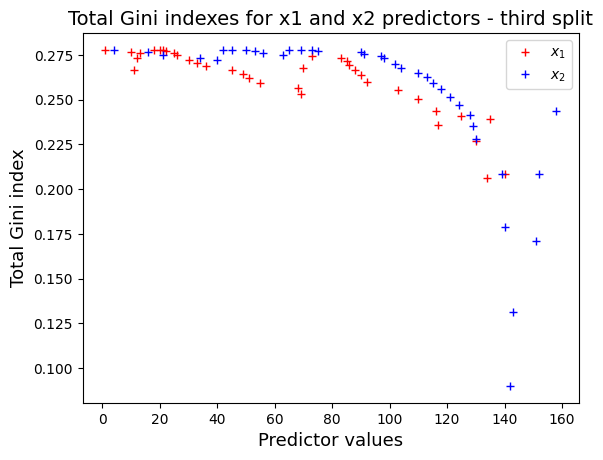

In [42]:
# Find the predictor and threshold for the split

# get unique values of x1 and x2 in this region
x1_unique_3split = np.unique(second_split_left_df['x1'].values)
x2_unique_3split = np.unique(second_split_left_df['x2'].values)

# Get total gini index for each predictor
tot_gini_x1_3split = get_total_gini(x1_unique_3split, 'x1', second_split_left_df)
tot_gini_x2_3split = get_total_gini(x2_unique_3split, 'x2', second_split_left_df)

plt.plot(x1_unique_3split, tot_gini_x1_3split, 'r+', label='$x_1$')
plt.plot(x2_unique_3split, tot_gini_x2_3split, 'b+', label='$x_2$')
plt.xlabel("Predictor values", fontsize="13")
plt.ylabel("Total Gini index", fontsize="13")
plt.title("Total Gini indexes for x1 and x2 predictors - third split", fontsize="14")
plt.legend()
plt.show()

In [43]:
report_splits(x1_unique_3split, x2_unique_3split,
              tot_gini_x1_3split, tot_gini_x2_3split)

The lowest total gini score is achieved when splitting on x2 at the value 142.


In [44]:
### edTest(test_third_threshold) ###

# The value to split on
x2_threshold_3split = 
x2_threshold_3split

SyntaxError: invalid syntax (561553396.py, line 4)